# Import Libraries

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import string
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
import matplotlib.pyplot as plt

from collections import Counter
# Read in tweet data
tweets = pd.read_csv('Tweets.csv')

df = tweets.copy()[['airline_sentiment', 'text']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\windows\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Pre-processing

In [2]:
print('Raw Dataframe:')
df.head(10)

Raw Dataframe:


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


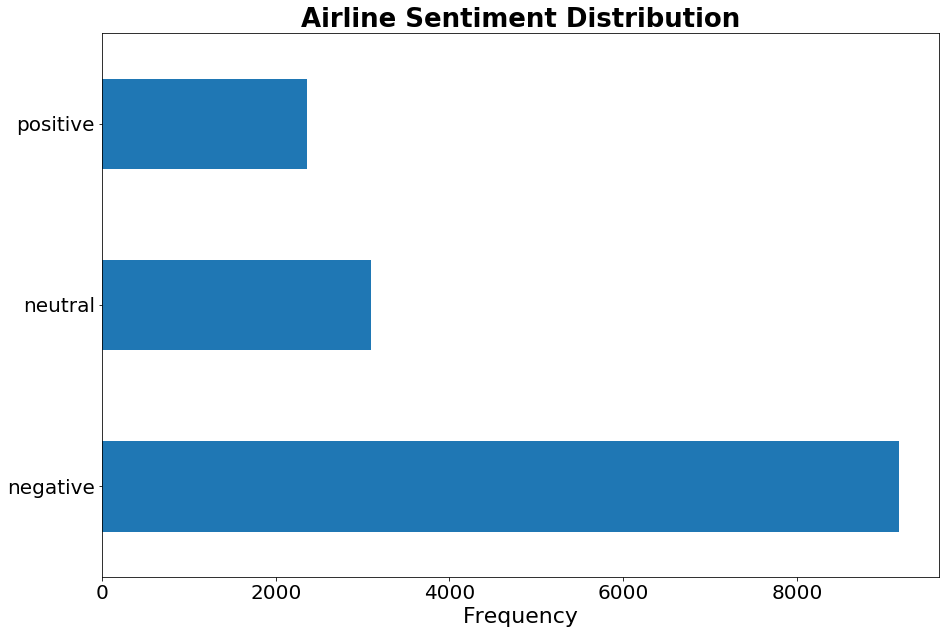

In [3]:
# Plot sentiment distribution
df['airline_sentiment'].value_counts().plot(kind = 'barh',
                                            figsize = (15,10));
plt.title('Airline Sentiment Distribution', 
          fontsize = 26, weight = 'bold')
plt.xlabel('Frequency', fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

# Define number of classes and number of tweets per class

In [4]:
n_class = 2
n_tweet = 2363

# Divide into number of classes
if n_class == 2:
    df_pos = df.copy()[df.airline_sentiment == 'positive'][:n_tweet]
    df_neg = df.copy()[df.airline_sentiment == 'negative'][:n_tweet]
    df_neu = pd.DataFrame()
    df = pd.concat([df_pos, df_neg], ignore_index=True).reset_index(drop=True)
elif n_class == 3:
    df_pos = df.copy()[df.airline_sentiment == 'positive'][:n_tweet]
    df_neg = df.copy()[df.airline_sentiment == 'negative'][:n_tweet]
    df_neu = df.copy()[df.airline_sentiment == 'neutral'][:n_tweet]
    df = pd.concat([df_pos, df_neg, df_neu], ignore_index=True).reset_index(drop=True)

# Define functions to process Tweet text and remove stop words
def ProTweets(tweet):
    tweet = ''.join(c for c in tweet if c not in string.punctuation)
    tweet = re.sub('((www\S+)|(http\S+))', 'urlsite', tweet)
    tweet = re.sub(r'\d+', 'contnum', tweet)
    tweet = re.sub(' +',' ', tweet)
    tweet = tweet.lower().strip()
    return tweet

def rmStopWords(tweet, stop_words):
    text = tweet.split()
    text = ' '.join(word for word in text if word not in stop_words)
    return text

# Reading a list of stop words and processing each line of tweets in the dataframe using the function we've defined above.

In [5]:
stopwords = [''.join(c for c in s if c not in string.punctuation) for s in stopwords]
stopwords = [t.encode('utf-8') for t in stopwords]



# Preprocess all tweet data

In [6]:
# Preprocess all tweet data
pro_tweets = []
for tweet in df['text']:
    processed = ProTweets(tweet)
    pro_stopw = rmStopWords(processed, stopwords)
    pro_tweets.append(pro_stopw)

df['text'] = pro_tweets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['airline_sentiment'], test_size=0.33, random_state=0)

df_train = pd.DataFrame()
df_test = pd.DataFrame()

df_train['text'] = X_train
df_train['airline_sentiment'] = y_train
df_train = df_train.reset_index(drop=True)

df_test['text'] = X_test
df_test['airline_sentiment'] = y_test
df_test = df_test.reset_index(drop=True)

# Start training (input training set df_train)

In [8]:
class TweetNBClassifier(object):

    def __init__(self, df_train):
        self.df_train = df_train
        self.df_pos = df_train.copy()[df_train.airline_sentiment == 'positive']
        self.df_neg = df_train.copy()[df_train.airline_sentiment == 'negative']
        self.df_neu = df_train.copy()[df_train.airline_sentiment == 'neutral']

    def fit(self):
        Pr_pos = df_pos.shape[0]/self.df_train.shape[0]
        Pr_neg = df_neg.shape[0]/self.df_train.shape[0]
        Pr_neu = df_neu.shape[0]/self.df_train.shape[0]
        self.Prior  = (Pr_pos, Pr_neg, Pr_neu)

        self.pos_words = ' '.join(self.df_pos['text'].tolist()).split()
        self.neg_words = ' '.join(self.df_neg['text'].tolist()).split()
        self.neu_words = ' '.join(self.df_neu['text'].tolist()).split()

        all_words = ' '.join(self.df_train['text'].tolist()).split()

        self.vocab = len(Counter(all_words))

        wc_pos = len(' '.join(self.df_pos['text'].tolist()).split())
        wc_neg = len(' '.join(self.df_neg['text'].tolist()).split())
        wc_neu = len(' '.join(self.df_neu['text'].tolist()).split())
        self.word_count = (wc_pos, wc_neg, wc_neu)
        return self


    def predict(self, df_test):
        class_choice = ['positive', 'negative', 'neutral']

        classification = []
        for tweet in df_test['text']:
            text = tweet.split()

            val_pos = np.array([])
            val_neg = np.array([])
            val_neu = np.array([])
            for word in text:
                tmp_pos = np.log((self.pos_words.count(word)+1)/(self.word_count[0]+self.vocab))
                tmp_neg = np.log((self.neg_words.count(word)+1)/(self.word_count[1]+self.vocab))
                tmp_neu = np.log((self.neu_words.count(word)+1)/(self.word_count[2]+self.vocab))
                val_pos = np.append(val_pos, tmp_pos)
                val_neg = np.append(val_neg, tmp_neg)
                val_neu = np.append(val_neu, tmp_neu)

            val_pos = np.log(self.Prior[0]) + np.sum(val_pos)
            val_neg = np.log(self.Prior[1]) + np.sum(val_neg)
            val_neu = np.log(self.Prior[2]) + np.sum(val_neu)

            probability = (val_pos, val_neg, val_neu)
            classification.append(class_choice[np.argmax(probability)])
        return classification


    def score(self, feature, target):

        compare = []
        for i in range(0,len(feature)):
            if feature[i] == target[i]:
                tmp ='correct'
                compare.append(tmp)
            else:
                tmp ='incorrect'
                compare.append(tmp)
        r = Counter(compare)
        accuracy = r['correct']/(r['correct']+r['incorrect'])
        return accuracy

# Running the classifier to see how well its done on our test data!

In [9]:
tnb = TweetNBClassifier(df_train)
tnb = tnb.fit()
predict = tnb.predict(df_test)
score = tnb.score(predict,df_test.airline_sentiment.tolist())
print(score)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log


0.926923076923077
